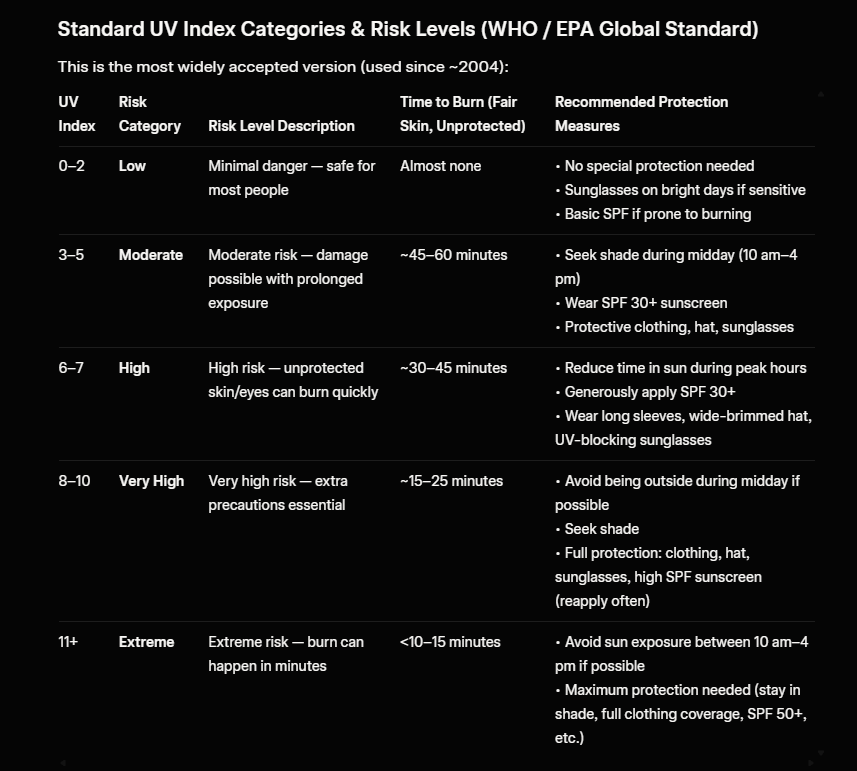
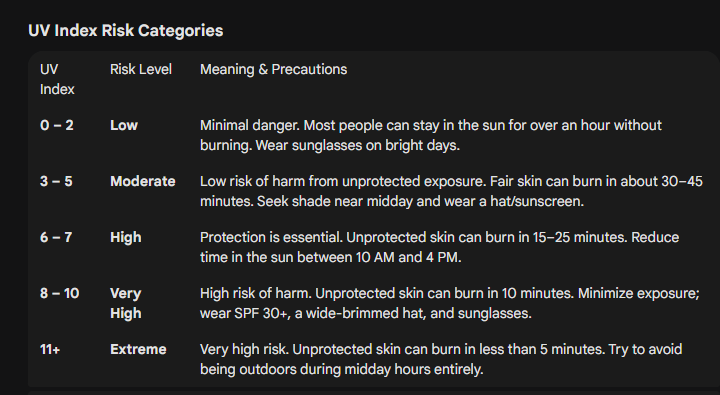

In [1]:
# # Features

# X = df[[
#     'solar_radiation', 
#     'month', 
#     'day', 
#     'precipitation', 
#     'humidity', 
#     'temperature(degree C)', 
#     'atmospheric_pressure', 
#     'windspeed', 
#     'dew_point'
# ]]

# # The target variable
# y = df['UV']